# Image Caption 小试牛刀
Author: HUST-马世拓

## 数据集
我们本次选取的数据集是来源于Flickr数据集。数据集给出了8096张图片和对应的caption描述，kaggle上一搜就会有。可以看看这个文本什么样子：

In [2]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

filename = "./Flickr8k.lemma.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])


1305564994_00513f9a5b.jpg#0	A man in street racer armor be examine the tire of another racer 's motorbike .
1305564994_00513f9a5b.jpg#1	Two racer drive a white bike down a road .
1305564994_00513f9a5b.jpg#2	Two motorist be ride along on their vehicle that be oddly design and color .
1305564994_00513


做一些基本的数据清洗

In [3]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        if len(line) < 2:
            continue
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [5]:
# convert the loaded descriptions into a vocabulary of words
def getVocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = getVocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 7069


In [6]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')
print("Desciption.txt created")

Desciption.txt created


In [7]:
# load Train Data
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = './Flickr_8k.trainImages.txt'
train_names = load_set(filename)
train_names = train_names[0:300]
print('Train size: %d' % len(train_names))

Directroy_path = './trainset/images/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 300


我们现在读取一下数据集，这里为了方便我们截取一些读取和调试看看。

In [8]:
filename = './Flickr_8k.testImages.txt'
test_names = load_set(filename)
test_names = test_names[0:50]
print('Test Size: %d' % len(test_names))

Directroy_path = './testset/images/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 50


In [9]:
# we r extracting train data captions such that, each captions starts with 'startseq' and ends with 'endseq
def load_clean_descriptions(filename, dataset):
    # load document
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train_names)

print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=300


In [10]:
# Save train_descriptions
import pickle
with open("./train_descriptions.pkl", "wb") as encoded_pickle:
    pickle.dump(train_descriptions, encoded_pickle)

接下来我们利用opencv打开图片看看这些图片的样子。另外读取图片时应用opencv的话读取格式是BGR，需要转换到RGB否则图像会很阴间。为了适配后面图像特征提取，我将图像尺寸规约一下。

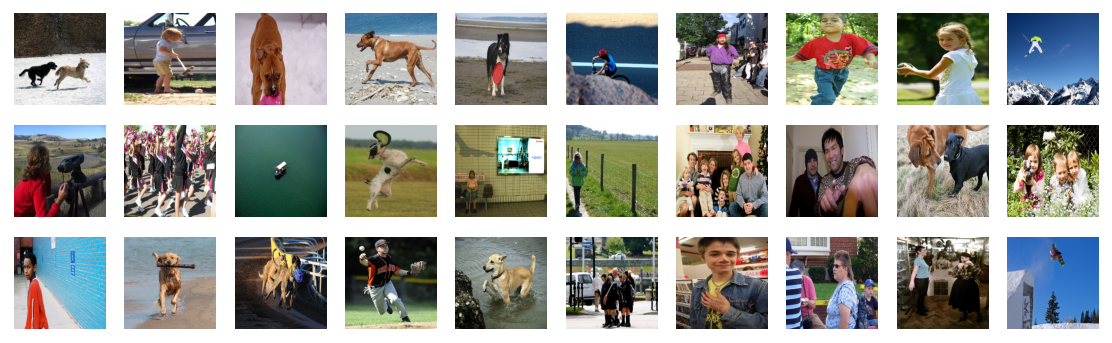

In [11]:
import cv2
import numpy as np
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = cv2.imread(image_path)
    img = cv2.resize(img,(224,224))
    x = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    x = x/255
    return x
import matplotlib.pyplot as plt
%matplotlib inline

# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
i=1
for image in train_img[0:30]:
    img=preprocess(image)[0]
    plt.axis("off")
    plt.subplot(3, 10, i)
    plt.axis("off")
    i=i+1
    plt.imshow(img)
plt.show()

## 模型
这里我们的模型准备先拿BRNN作为Baseline，使用ResNet模型提取图像特征以后，将文本作为语义特征输入，和图像特征一同送入LSTM训练。每训练一张图和一个词我们能推断出下一个词从而获取整个序列信息。

In [12]:
import mindspore as ms
import mindspore.nn as nn
import mindspore as ms

from mindvision.classification.models import resnet18
from mindvision.engine.loss import CrossEntropySmooth
resnet = resnet18(pretrained=True)  # pretrained ImageNet ResNet-101
modules = list(resnet.cells())[:-2]
modules.append(nn.AvgPool2d(kernel_size=7))
resnet = nn.SequentialCell(modules)
print(resnet)

SequentialCell<
  (0): ResNet<
    (conv1): ConvNormActivation<
      (features): SequentialCell<
        (0): Conv2d<input_channels=3, output_channels=64, kernel_size=(7, 7), stride=(2, 2), pad_mode=pad, padding=3, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
        (1): BatchNorm2d<num_features=64, eps=1e-05, momentum=0.09999999999999998, gamma=Parameter (name=0.conv1.features.1.gamma, shape=(64,), dtype=Float32, requires_grad=True), beta=Parameter (name=0.conv1.features.1.beta, shape=(64,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=0.conv1.features.1.moving_mean, shape=(64,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=0.conv1.features.1.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)>
        (2): ReLU<>
        >
      >
    (max_pool): MaxPool2d<kernel_size=3, stride=2, pad_mode=SAME>
    (layer1): SequentialCell<
      (0): ResidualBlockBase<
        (conv1): ConvNorm

In [13]:
yangben=preprocess(train_img[0]).transpose(0,3,1,2)
yangben=ms.Tensor(yangben,ms.float32)
resnet(yangben).shape

(1, 512, 1, 1)

In [14]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image).transpose(0,3,1,2)
    image = ms.Tensor(image,ms.float32) 
    v = resnet(image).asnumpy()
    v = np.reshape(v, v.shape[1]) 
    return v

为了方便，同时防止掉线我把图像压缩后的结果保存下来

In [15]:
from time import time
from tqdm import tqdm
# Encoding all the Training Dataset to a 2048 Dimension Vectors, Run this once
start = time()
k=0
encoded_train = {}
for img in tqdm(train_img):
 
    encoded_train[img[len('./trainset/images/'):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 300/300 [00:31<00:00,  9.62it/s]


Time taken in seconds = 31.19824719429016


In [16]:
# Encoding all the Test Dataset to a 2048 Dimension Vectors, Run this once
start = time()
encoded_test = {}
for img in tqdm(test_img):
    encoded_test[img[len('./testset/images/'):]] = encode(img)
print("Time taken in seconds =", time()-start)

100%|██████████| 50/50 [00:05<00:00,  9.87it/s]

Time taken in seconds = 5.0700695514678955


## 文本信息
这一步开始我们提取文本信息，利用glove词向量进行嵌入

In [17]:
# Save Train features
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train, encoded_pickle)

In [18]:
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_test, encoded_pickle)

In [19]:
# Loading Image Features
train_features = pickle.load(open("./encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=300


In [20]:
train_descriptions = pickle.load(open("./train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=300


In [21]:
# Create a list of all the training captions
train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        train_captions.append(cap)
len(train_captions)

1500

In [22]:
threshold = 7
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        if w not in word_counts:
            word_counts[w] = 0
        word_counts[w] += 1

vocab = [w for w in word_counts if word_counts[w] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 1411 -> 302


这叫word2id，在我学自然语言处理的时候经典的NER任务就得用它

In [23]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

303

In [24]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

303

In [25]:
# calculate the length of the description with the most words
def max_length(descriptions): 
    max_l = -1e9
    for key, cap in descriptions.items():
        for line in cap:
            max_l = max(max_l, len(line.split(' ')))
    return max_l

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 32


Glove的预训练词向量可以下载，我这里在CSDN上白嫖了同学的会员下的

In [26]:
import os
glove_dir = './'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:20, 19509.01it/s]

Found 400000 word vectors.


In [27]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoix.items()):
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector

100%|██████████| 302/302 [00:00<00:00, 302454.59it/s]


In [28]:
embedding_matrix.shape # (vocab, embedding_dim)

(303, 200)

In [29]:
with open('./Embedding_Matrix.pkl', 'wb') as embedding_pickle:
    pickle.dump(embedding_matrix, embedding_pickle)

In [30]:
with open('./wordtoix.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [31]:
train_features = pickle.load(open("./encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=300


In [32]:
train_descriptions = pickle.load(open("./train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=300


In [33]:
embedding_matrix = pickle.load(open("./Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (303, 200)


In [34]:
# Loading wordtoix
wordtoix = pickle.load(open("./wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 302


In [35]:
max_length = 150 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [36]:
max_length = 40 # computer from file 2
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [37]:
train_features['2513260012_03d33305cf.jpg'].shape

(512,)

In [38]:
max_length = 150
vocab_size = embedding_matrix.shape[0]
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
embedding_dim = embedding_matrix.shape[1]
max_length,vocab_size ,embedding_dim

(150, 303, 200)

## 正式模型构建
这部分开始我们开始构建模型。

In [39]:
from mindspore import nn, ops
class BRNN(nn.Cell):
    def __init__(self,
                 img_shape=(512,),
                 text_shape=(40,)):
        super(BRNN, self).__init__()
        self.img_channel=nn.SequentialCell([
            nn.Dropout(0.5),
            nn.Dense(in_channels=img_shape[0],out_channels=256,activation='relu')
        ])
        self.text_channel=nn.SequentialCell([
            nn.Embedding(vocab_size, embedding_dim,padding_idx=0,embedding_table=ms.Tensor(embedding_matrix,dtype=ms.float32)),
            nn.Dropout(0.5),
            nn.LSTM(input_size=200,hidden_size=256),
            #nn.Dense(in_channels=text_shape[0]*text_shape[1]*256,out_channels=256)
            
        ])
        self.add=ops.Add()
        self.comb=nn.SequentialCell([
            nn.Dense(in_channels=256,out_channels=256),
            nn.Dense(in_channels=256,out_channels=vocab_size,activation='softmax')
        ])
    def construct(self, x, y):
        """Attention construct."""
        x=x.T
        fe1=self.img_channel(x)
        se1=self.text_channel(y)[0].transpose(1,0,2)
        se1=nn.Flatten()(se1)
        se1=nn.Dense(se1.shape[1],256)(se1)
        #se1=nn.Dense(in_channels=200*256,out_channels=256)(se1)
        dec1=self.add(fe1,se1)
        #print(dec1.shape)
        #dec1=ops.MatMul()(se1,fe1.T)
        out=self.comb(dec1)
        return out


In [40]:
brnn=BRNN()
print(brnn)

BRNN<
  (img_channel): SequentialCell<
    (0): Dropout<keep_prob=0.5>
    (1): Dense<
      input_channels=512, output_channels=256, has_bias=True, activation=ReLU<>
      (activation): ReLU<>
      >
    >
  (text_channel): SequentialCell<
    (0): Embedding<vocab_size=303, embedding_size=200, use_one_hot=False, embedding_table=Parameter (name=text_channel.0.embedding_table, shape=(303, 200), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=0>
    (1): Dropout<keep_prob=0.5>
    (2): LSTM<
      (rnn): _DynamicLSTMCPUGPU<>
      (reverse): _Reverse<>
      (reverse_sequence): _ReverseSequence<>
      (dropout_op): Dropout<keep_prob=1.0>
      >
    >
  (comb): SequentialCell<
    (0): Dense<input_channels=256, output_channels=256, has_bias=True>
    (1): Dense<
      input_channels=256, output_channels=303, has_bias=True, activation=Softmax<>
      (activation): Softmax<>
      >
    >
  >


先初始化两个张量小试一手，怕网络的张量计算维度不对

In [41]:
from mindspore import set_seed
set_seed(1)
img=ms.Tensor(shape=(512,1), dtype=ms.float32, init=ms.common.initializer.One())
text=ms.Tensor(shape=(58,1), dtype=ms.int32, init=ms.common.initializer.One())
brnn(img,text)

Tensor(shape=[1, 303], dtype=Float32, value=
[[3.32867843e-003, 3.30568664e-003, 3.28447320e-003 ... 3.29394499e-003, 3.28921224e-003, 3.31863109e-003]])

In [42]:
# 定义优化器
network_opt = nn.Adam(params=brnn.trainable_params(), learning_rate=0.02)
# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1,classes_num=vocab_size)
# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}
# 初始化模型
model = ms.Model(brnn, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

In [43]:
def pad_sequences(list_in_seq,maxlen):
    in_seq=list_in_seq[0]
    if len(in_seq)<maxlen:
        while len(in_seq)<maxlen:
            in_seq.append(0)
    else:
        in_seq=in_seq[0:maxlen]
    return in_seq
def to_categorical(list_out_seq,num_classes=vocab_size):
    arr=np.zeros((vocab_size,1))
    arr[list_out_seq[0]]=1
    return arr.T
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append([photo])
                    X2.append([in_seq])
                    y.append([out_seq])
            # yield the batch data
            if n==num_photos_per_batch:
                yield [ms.Tensor(X1,dtype=ms.float32), ms.Tensor(X2,dtype=ms.float32), ms.Tensor(y,dtype=ms.float32)]
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y
max_length=50
generator=data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
i=0
for x1,x2,y in generator:
    print(x1.shape)

(128, 1, 512)
(142, 1, 512)
(153, 1, 512)
(160, 1, 512)
(206, 1, 512)
(184, 1, 512)
(137, 1, 512)
(152, 1, 512)
(163, 1, 512)
(166, 1, 512)
(156, 1, 512)
(156, 1, 512)
(137, 1, 512)
(157, 1, 512)
(142, 1, 512)
(150, 1, 512)
(159, 1, 512)
(173, 1, 512)
(157, 1, 512)
(162, 1, 512)
(156, 1, 512)
(209, 1, 512)
(154, 1, 512)
(137, 1, 512)
(175, 1, 512)
(166, 1, 512)
(137, 1, 512)
(191, 1, 512)
(197, 1, 512)
(167, 1, 512)
(156, 1, 512)
(155, 1, 512)
(155, 1, 512)
(181, 1, 512)
(159, 1, 512)
(198, 1, 512)
(170, 1, 512)
(183, 1, 512)
(159, 1, 512)
(162, 1, 512)
(180, 1, 512)
(146, 1, 512)
(220, 1, 512)
(162, 1, 512)
(157, 1, 512)
(170, 1, 512)
(163, 1, 512)
(176, 1, 512)
(206, 1, 512)
(187, 1, 512)
(147, 1, 512)
(151, 1, 512)
(193, 1, 512)
(179, 1, 512)
(147, 1, 512)
(165, 1, 512)
(189, 1, 512)
(180, 1, 512)
(195, 1, 512)
(165, 1, 512)
(175, 1, 512)
(177, 1, 512)
(179, 1, 512)
(166, 1, 512)
(166, 1, 512)
(193, 1, 512)
(169, 1, 512)
(193, 1, 512)
(173, 1, 512)
(203, 1, 512)
(213, 1, 512)
(179, 

KeyboardInterrupt: 

这个位置我本来是参考了一个tensorflow版本的代码，但是我发现这个地方不太行。尝试失败。在整了三个小时准备放弃的时候我看官方文档有基于现有python变量和csv表格构造数据集，能不能根据这个来呢？

In [44]:
x1=[]
x2=[]
y=[]
max_length=150
i=0
for key, desc_list in train_descriptions.items():
    #x1.append(train_features[key+'.jpg'])
    sequence=' '.join(i for i in desc_list)
    desc=[wordtoix[word] for word in sequence.split(' ') if word in wordtoix]
    for i in range(1,len(desc)):
        img=train_features[key+'.jpg'].reshape(512,1)
        x1.append(ms.Tensor(img,dtype=ms.float32))
        seq=desc[0:i]
        if len(seq)<max_length:
            seq=seq+[0]*(max_length-len(seq))
        else:
            seq=seq[0:max_length]
        x2.append(ms.Tensor(np.array([seq]).T,dtype=ms.int32))
        soft=np.zeros((1,vocab_size))
        soft[0,desc[i]]=1
        y.append(soft)
print(len(x1))

18097


In [45]:
brnn(x1[0],x2[0])

Tensor(shape=[1, 303], dtype=Float32, value=
[[3.33779585e-003, 3.29426606e-003, 3.28461290e-003 ... 3.28395958e-003, 3.30421724e-003, 3.29839811e-003]])

这是更贴近真实网络训练的MindSpore风格，然鹅我可能hold不住。这个地方如果用我的面向对象的这种写法这个类是有bug的，我也不知道为嘛。参照的是course下PFLD多通道的那个写法但是就是不成功。于是我把目光放在了Numpy生成DataGenerator上。

In [46]:
class DatasetsFlicker():
    """
    Read the 300W comment file in the specified format.

    Args:
        file_dir: str. File path after processing (data enhancement).
        transforms: function. Function to convert a PIL image or a numpy.ndarray
            of shape (H, W, C) to a numpy.ndarray of type (C, H, W).
    """

    def __init__(self):
        self.line = 0
        self.img = []
        self.text = []
        self.y = []
        

    def __getitem__(self,index):
        """ Get a list of datasets """
        for key, desc_list in train_descriptions.items():
            #x1.append(train_features[key+'.jpg'])
            sequence=' '.join(i for i in desc_list)
            desc=[wordtoix[word] for word in sequence.split(' ') if word in wordtoix]
            for index in range(1,len(desc)):
                img=train_features[key+'.jpg'].reshape(512,1)
                #self.img.append(ms.Tensor(img,dtype=ms.float32))
                self.img.append(img)
                seq=desc[0:i]
                if len(seq)<max_length:
                    seq=seq+[0]*(max_length-len(seq))
                else:
                    seq=seq[0:max_length]
                #self.text.append(ms.Tensor(np.array([desc[0:i]]),dtype=ms.int32))
                self.text.append(np.array([seq],dtype=np.int32))
                soft=np.zeros((1,vocab_size))
                soft[0,desc[i]]=1
                self.y.append(soft)
        self.line=len(self.img)

        return [self.img, self.text, self.y]

    def __len__(self):
        """ Get the length of each line """
        return self.line

In [47]:
dataset = ms.dataset.GeneratorDataset([x1,x2,y],
                                 ["img", "text", "y"],
                                 num_parallel_workers=4,
                                 shuffle=True)

In [48]:
x1=[]
x2=[]
y=[]
max_length=150
i=0
for key, desc_list in train_descriptions.items():
    #x1.append(train_features[key+'.jpg'])
    sequence=' '.join(i for i in desc_list)
    desc=[wordtoix[word] for word in sequence.split(' ') if word in wordtoix]
    for i in range(1,len(desc)):
        img=train_features[key+'.jpg'].reshape(512,1)
        x1.append(img)
        seq=desc[0:i]
        if len(seq)<max_length:
            seq=seq+[0]*(max_length-len(seq))
        else:
            seq=seq[0:max_length]
        x2.append(np.array([seq],dtype=np.int32).T)
        soft=np.zeros((1,vocab_size))
        soft[0,desc[i]]=1
        y.append(soft)
print(len(x1))

18097


In [49]:
data={'img':x1,'text':x2,'word':y}
dataset=ms.dataset.NumpySlicesDataset(data=data,column_names=['img','text','word'])
dataset = dataset.batch(64, column_order=['img','text','word'])

这样我的数据集才算构架起来。但是怎么训，下面这段代码是参考了官方教程里面基于LSTM的情感分类的，由于我这里要预测多词，所以把损失函数从二分类损失改成多分类损失。然而，**有问题！！！**
这个地方训练它不收敛！我也不知道是哪里出的故障，但真没时间也不知道怎么改了（笑哭）

In [50]:
loss = nn.MultiClassDiceLoss()
net_with_loss = nn.WithLossCell(brnn, loss)
optimizer = nn.Adam(brnn.trainable_params(), learning_rate=0.02)
train_one_step = nn.TrainOneStepCell(net_with_loss, optimizer)

def train_one_epoch(model, train_dataset, epoch=0):
    model.set_train()
    total = train_dataset.get_dataset_size()
    loss_total = 0
    step_total = 0
    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in train_dataset.create_tuple_iterator():
            loss = brnn(i[0].transpose(2,1,0)[0],i[1].transpose(2,1,0)[0])
            loss_total += loss.asnumpy().sum()
            step_total += 1
            t.set_postfix(loss=loss_total/step_total)
            t.update(1)

def binary_accuracy(preds, y):
    """
    计算每个batch的准确率
    """

    # 对预测值进行四舍五入
    rounded_preds = np.around(preds)
    correct = (rounded_preds == y).astype(np.float32)
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, test_dataset, criterion, epoch=0):
    total = test_dataset.get_dataset_size()
    epoch_loss = 0
    epoch_acc = 0
    step_total = 0
    model.set_train(False)

    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in test_dataset.create_tuple_iterator():
            predictions = brnn(i[0].transpose(2,1,0)[0],i[1].transpose(2,1,0)[0]).T
            #print(predictions.shape,i[2].shape)
            loss = criterion(predictions, i[2].transpose(1,2,0)[0])
            epoch_loss += loss.asnumpy().sum()

            acc = binary_accuracy(predictions.asnumpy(), i[2].transpose(1,2,0)[0].asnumpy())
            epoch_acc += acc

            step_total += 1
            t.set_postfix(loss=epoch_loss/step_total, acc=epoch_acc/step_total)
            t.update(1)

    return epoch_loss / total

from mindspore import save_checkpoint

num_epochs = 5
best_valid_loss = float('inf')
ckpt_file_name = os.path.join('./', 'image-caption.ckpt')

for epoch in range(num_epochs):
    train_one_epoch(train_one_step, dataset, epoch)
    valid_loss = evaluate(brnn,dataset , loss, epoch)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(brnn, ckpt_file_name)


Epoch 4: 100%|██████████| 283/283 [00:38<00:00,  7.42it/s, acc=63.7, loss=0.971]


现在我们来推理一张图片试试看看

In [51]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [52]:
# Loading wordtoix
wordtoix = pickle.load(open("./wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 302


In [53]:
ixtoword = {}
for word, i in wordtoix.items():
    ixtoword[i] = word

In [54]:
in_text='startseq'
for i in range(max_length):
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    if len(sequence)<max_length:
        sequence+=[0]*(max_length-len(sequence))
    else:
        sequence=sequence[0:max_length]
    #sequence = pad_sequences([sequence], maxlen=max_length)
len(sequence)

150

这个推理策略是贪心的，从startseq开始，一直到endseq为止，我们将在每一步添加概率最大的一个词到序列里面，每添加一次就获取一次词向量，然后和图像特征一块再对新的词向量和图向量做融合升华。然而这个地方……最大序列长150的情况下根本不知道停下，而且预测都是同一个单词。虽然有些单词和图片确实说得过去但更多我想还是偶然因素较大。

In [55]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        if len(sequence)<max_length:
            sequence+=[0]*(max_length-len(sequence))
        else:
            sequence=sequence[0:max_length]
        photo=ms.Tensor(photo,dtype=ms.float32)
        sequence=ms.Tensor(np.array([sequence]),dtype=ms.int32)
        yhat = brnn(photo,sequence).asnumpy()
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

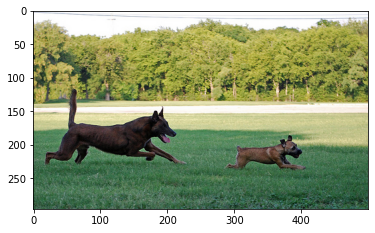

Greedy: hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold hold


In [57]:
z = 18
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((512,1))
x=plt.imread('./testset/images/'+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

## 改进模型的想法
我们可以在每个时间步长上用attention去扫描，然后分析并可视化。我认为这个策略是很合适的

In [58]:
from mindspore import nn, ops

class Attention(nn.Cell):
    def __init__(self,
                 dim: int,
                 num_heads: int = 8,
                 keep_prob: float = 1.0,
                 attention_keep_prob: float = 1.0):
        super(Attention, self).__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = ms.Tensor(head_dim ** -0.5)

        self.qkv = nn.Dense(dim, dim * 3)
        self.attn_drop = nn.Dropout(attention_keep_prob)
        self.out = nn.Dense(dim, dim)
        self.out_drop = nn.Dropout(keep_prob)

        self.mul = ops.Mul()
        self.reshape = ops.Reshape()
        self.transpose = ops.Transpose()
        self.unstack = ops.Unstack(axis=0)
        self.attn_matmul_v = ops.BatchMatMul()
        self.q_matmul_k = ops.BatchMatMul(transpose_b=True)
        self.softmax = nn.Softmax(axis=-1)

    def construct(self, x,y):
        """Attention construct."""
        b, n, c = x.shape

        # 最初的输入向量首先会经过Embedding层映射成Q(Query)，K(Key)，V(Value)三个向量
        # 由于是并行操作，所以代码中是映射成为dim*3的向量然后进行分割
        x = ops.Concat()((x,y))
        qkv = self.qkv(x)

        #多头注意力机制就是将原本self-Attention处理的向量分割为多个Head进行处理
        qkv = self.reshape(qkv, (b, n, 3, self.num_heads, c // self.num_heads))
        qkv = self.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = self.unstack(qkv)

        # 自注意力机制的自注意主要体现在它的Q，K，V都来源于其自身
        # 也就是该过程是在提取输入的不同顺序的向量的联系与特征
        # 最终通过不同顺序向量之间的联系紧密性（Q与K乘积经过Softmax的结果）来表现出来
        attn = self.q_matmul_k(q, k)
        attn = self.mul(attn, self.scale)
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        # 其最终输出则是通过V这个映射后的向量与QK经过Softmax结果进行weight sum获得
        # 这个过程可以理解为在全局上进行自注意表示
        out = self.attn_matmul_v(attn, v)
        out = self.transpose(out, (0, 2, 1, 3))
        out = self.reshape(out, (b, n, c))
        out = self.out(out)
        out = self.out_drop(out)

        return out

In [63]:
class BRNN_att(nn.Cell):
    def __init__(self,
                 img_shape=(512,),
                 text_shape=(40,)):
        super(BRNN_att, self).__init__()
        self.img_channel=nn.SequentialCell([
            nn.Dropout(0.5),
            nn.Dense(in_channels=img_shape[0],out_channels=256,activation='relu')
        ])
        self.text_channel=nn.SequentialCell([
            nn.Embedding(vocab_size, embedding_dim,padding_idx=0,embedding_table=ms.Tensor(embedding_matrix,dtype=ms.float32)),
            nn.Dropout(0.5),
            nn.LSTM(input_size=200,hidden_size=256),
            #nn.Dense(in_channels=text_shape[0]*text_shape[1]*256,out_channels=256)
            
        ])
        self.add=ops.Add(dim=256)
        self.comb=nn.SequentialCell([
            nn.Dense(in_channels=256,out_channels=256),
            nn.Dense(in_channels=256,out_channels=vocab_size,activation='softmax')
        ])
        self.att=Attention()
    def construct(self, x, y):
        """Attention construct."""
        x=x.T
        fe1=self.img_channel(x)
        se1=self.text_channel(y)[0].transpose(1,0,2)
        se1=nn.Flatten()(se1)
        se1=nn.Dense(se1.shape[1],256)(se1)
        #se1=nn.Dense(in_channels=200*256,out_channels=256)(se1)
        dec1=self.att(fe1,se1)
        #print(dec1.shape)
        #dec1=ops.MatMul()(se1,fe1.T)
        out=self.comb(dec1)
        return out

In [ ]:
bra=BRNN_att()
loss = nn.MultiClassDiceLoss()
net_with_loss = nn.WithLossCell(bra, loss)
optimizer = nn.Adam(brnn.trainable_params(), learning_rate=0.02)
train_one_step = nn.TrainOneStepCell(net_with_loss, optimizer)

def train_one_epoch(model, train_dataset, epoch=0):
    model.set_train()
    total = train_dataset.get_dataset_size()
    loss_total = 0
    step_total = 0
    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in train_dataset.create_tuple_iterator():
            loss = brnn(i[0].transpose(2,1,0)[0],i[1].transpose(2,1,0)[0])
            loss_total += loss.asnumpy().sum()
            step_total += 1
            t.set_postfix(loss=loss_total/step_total)
            t.update(1)

def binary_accuracy(preds, y):
    """
    计算每个batch的准确率
    """

    # 对预测值进行四舍五入
    rounded_preds = np.around(preds)
    correct = (rounded_preds == y).astype(np.float32)
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, test_dataset, criterion, epoch=0):
    total = test_dataset.get_dataset_size()
    epoch_loss = 0
    epoch_acc = 0
    step_total = 0
    model.set_train(False)

    with tqdm(total=total) as t:
        t.set_description('Epoch %i' % epoch)
        for i in test_dataset.create_tuple_iterator():
            predictions = bra(i[0].transpose(2,1,0)[0],i[1].transpose(2,1,0)[0]).T
            #print(predictions.shape,i[2].shape)
            loss = criterion(predictions, i[2].transpose(1,2,0)[0])
            epoch_loss += loss.asnumpy().sum()

            acc = binary_accuracy(predictions.asnumpy(), i[2].transpose(1,2,0)[0].asnumpy())
            epoch_acc += acc

            step_total += 1
            t.set_postfix(loss=epoch_loss/step_total, acc=epoch_acc/step_total)
            t.update(1)

    return epoch_loss / total

from mindspore import save_checkpoint

num_epochs = 5
best_valid_loss = float('inf')
ckpt_file_name = os.path.join('./', 'image-caption.ckpt')

for epoch in range(num_epochs):
    train_one_epoch(train_one_step, dataset, epoch)
    valid_loss = evaluate(brnn,dataset , loss, epoch)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(brnn, ckpt_file_name)


## 从生成式模型的角度考虑
我们认为既然GAN能做图像生成那就能做文本生成，更能做图像与文本的多模态生成式模型。那么这个地方完全可以试试DCGAN一类方法。

GAN的一类模型熟悉与使用由另一位同学完成。我这里就试试这俩吧。